# Regularized linear regression and bias vs variance

## 1 Regularized Linear Regression

"...you will implement regularized linear regression to predict the amount of water flowing out of a dam using the change of water level in a reservoir."

### 1.1 Visualizing the dataset

In [1]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize

In [2]:
# Load training data
data = scipy.io.loadmat('data/ex5data1.mat')
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y', 'Xtest', 'ytest', 'Xval', 'yval'])

In [3]:
# training data X, y
X = data['X']
y = data['y']

In [4]:
X.shape

(12, 1)

In [5]:
# cross-validation data Xval, yval
Xval = data['Xval']
yval = data['yval']

In [6]:
Xval.shape

(21, 1)

In [7]:
# test data Xtest, ytest
Xtest = data['Xtest']
ytest = data['ytest']

In [8]:
Xtest.shape

(21, 1)

In [9]:
m = X.shape[0] # number of training examples

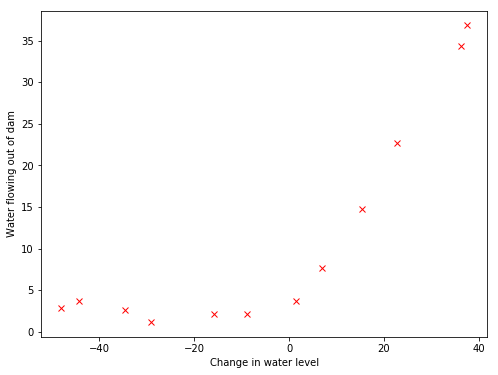

In [10]:
# Plot training data
plt.figure(figsize=(8,6))
plt.plot(X, y, 'rx')
plt.xlabel('Change in water level')
plt.ylabel('Water flowing out of dam')
plt.show()

### 1.2 Regularized linear regression cost function

In [11]:
# complete the code in the file linearRegCostFunction.m
# vectorize your code and avoid writing loops
# You should expect to see an output of 303.993.

In [12]:
def linear_reg_cost_function(X, y, theta, Lambda):
    '''
    Computes the cost of using theta as the parameter for linear regression to fit
    the data points in X and y, with regularisation constant Lambda.
    Returns the cost in J and the gradient in grad.
    '''

    theta = np.reshape(theta, (X.shape[1], 1))  # undo the fact that scipy.minimize needs flat gradient output
                                                # (see comments by grad = np.ndarray.flatten(grad))
    
    ## Cost
    J = 0
    grad = np.zeros(theta.shape)
    
    m = len(y) # number of examples
    
    J = 1/(2*m) * np.sum((np.dot(X, theta) - y)**2) + Lambda/(2*m) * np.sum(theta[1:]**2)
        

    ## Gradient
    grad[0] = 1/m * np.sum(np.dot((np.dot(X, theta) - y).T, X)[:,0])
    grad[1:] = 1/m * np.sum(np.dot((np.dot(X, theta) - y).T, X)[:,1:]) + Lambda/m * theta[1:]
       
    grad = np.ndarray.flatten(grad) # scipy.minimize requires a flat gradient output,
                                    # see https://stackoverflow.com/q/8752169/8291169
    
#     grad[0] = 1/m * np.sum(((np.dot(X, theta) - y) * X)[:,0])
#     grad[1:] = 1/m * np.sum(((np.dot(X, theta) - y) * X)[:,1:]) + Lambda/m * theta[1:]
    
    return J, grad

In [13]:
theta = np.array([[1],[1]]) # lots of square brackets to enforce shape = (2,1)
# Add a column of ones to X for bias
J = linear_reg_cost_function(np.column_stack((np.ones(m), X)), y, theta, 1)[0]

In [14]:
print('Cost at theta = [1, 1]:', J)
print('Expected cost: 303.993192')

Cost at theta = [1, 1]: 303.99319222
Expected cost: 303.993192


### 1.3 Regularized linear regression gradient

In [15]:
# Gradient calculation implemented in linear_reg_cost_function()

In [16]:
J, grad = linear_reg_cost_function(np.column_stack((np.ones(m), X)), y, theta, 1)

In [17]:
print('Gradient at theta = [1, 1]:\n', grad)
print('\nExpected gradient:\n[[-15.303016]\n[598.250744]]')

Gradient at theta = [1, 1]:
 [ -15.30301567  598.25074417]

Expected gradient:
[[-15.303016]
[598.250744]]


### 1.4 Fitting linear regression

In [18]:
def train_linear_reg(X, y, Lambda):
    '''
    Trains linear regression using dataset (X, y) and regularization parameter Lambda.
    Returns the trained parameters theta.
    '''
    
    theta = np.zeros((X.shape[1], 1))
    #theta = np.array([[1],[1]])

    def cost_func(t):
        return linear_reg_cost_function(X, y, t, Lambda)
    
    res = minimize(fun=cost_func, x0=theta, method='CG', jac=True, options={'maxiter':200})
    theta = res.x
    
    return theta

In [19]:
# Train linear regression with Lambda = 0
# We expect a very poor fit because we're trying to fit non-linear data with a straight line

Lambda = 0
theta = train_linear_reg(np.column_stack((np.ones(m), X)), y, Lambda)
theta

array([ 13.08790351,   0.36777923])

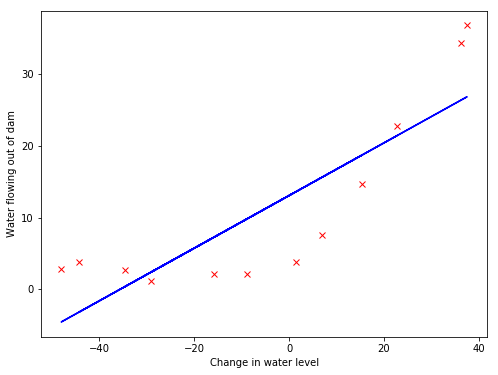

In [27]:
# Plot fit and data
plt.figure(figsize=(8,6))
plt.plot(X, y, 'rx')
plt.plot(X, np.dot(np.column_stack((np.ones(m), X)), theta), 'b-')
plt.xlabel('Change in water level')
plt.ylabel('Water flowing out of dam')
plt.show()